#  RNN 预测SIN 函数



预测正弦曲线 ， 可以用多对一RNN模型, 本教程用Tensorflow 实现了RNN 和LSTM。 

具体Rnn 和LSTM cell 是调用tf 的实现，tf.contrib.rnn.BasicRNNCell 和 tf.contrib.rnn.BasicLSTMCell

In [1]:
from sklearn import datasets
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.optimizers import SGD, Adam
print(tf.__version__)
print(keras.__version__)

Using TensorFlow backend.


1.14.0
2.0.9


## 制作玩具数据集

In [119]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi *x /T)

def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2* T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high = 1.0, size =len(x))
    
    return sin(x) + noise, x

In [120]:
T = 100
f, x = toy_problem(T)
toy_x = x
toy_y = f
real = [ sin(i) for i in range(2*T)]

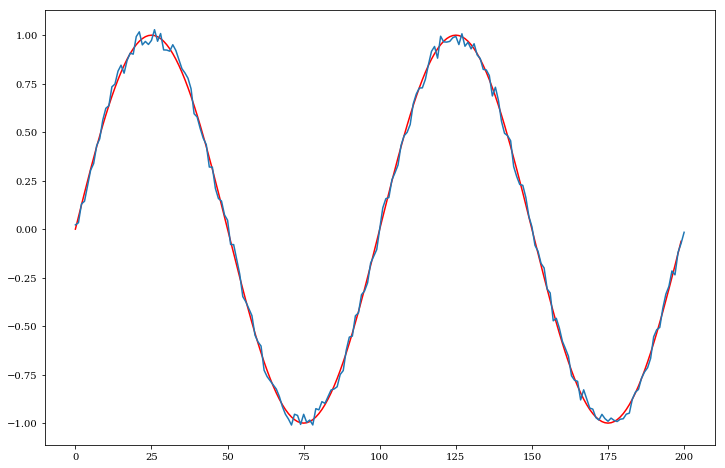

In [138]:
plt.figure(figsize=(12,8))
plt.plot(real , color='red')
plt.plot(toy_x, toy_y)

plt.show()

In [122]:
length_of_sequences = 2 * T
maxlen = 25

data = []
target = []

for i in range(0, length_of_sequences -maxlen+1):
    data.append(f[i: i+ maxlen]) # 过去25个预测未来一个
    target.append(f[i+maxlen])

|  X   | Y |
|  :----  | :----:  |
|通过 [1, 0+20] 的数据预测    | 0+21  |
|通过 [2, 1+20] 的数据预测     |  1 +21 |
| ...                       | ...   |
|通过 [n, n+20] 的数据预测    | n +21 |


In [123]:
print("data", data[1])
print("target", target[1])
print("======= [n, n+20] 预测 n+21 ")
for i in range(5):
    print("[... {}]  ==> {:.8f}\t".format(
        ( data[i][-3:]) , target[i]))

data [0.0328869  0.12983228 0.1438459  0.22500246 0.30348068 0.33807471
 0.43069098 0.4659547  0.56230882 0.62296694 0.6362966  0.73383919
 0.7478439  0.81435534 0.84524242 0.80402084 0.87046431 0.90714536
 0.9020914  0.99265109 1.01724248 0.94998495 0.96760914 0.95206128
 0.9730394 ]
target 1.0282624588282532
[... [0.94998495 0.96760914 0.95206128]]  ==> 0.97303940	
[... [0.96760914 0.95206128 0.9730394 ]]  ==> 1.02826246	
[... [0.95206128 0.9730394  1.02826246]]  ==> 0.96863516	
[... [0.9730394  1.02826246 0.96863516]]  ==> 1.00839205	
[... [1.02826246 0.96863516 1.00839205]]  ==> 0.92400079	


In [124]:
X = np.array(data).reshape(len(data), maxlen ,1)
Y = np.array(target).reshape(len(data), 1)
N_train = int(len(data) * 0.9)
N_validation= len(data) - N_train

X_train, X_validation , Y_train, Y_validation = train_test_split(X, Y , test_size = N_validation)

### X的维度 
X 测时间序列是 25， 同时只有一个维度的数据 ,所以是shape是 (-1, 25, 1)

In [125]:
print('X_train shape  {}'.format(X_train.shape))
print('Y_train shape  {}'.format(Y_train.shape))

X_train shape  (158, 25, 1)
Y_train shape  (158, 1)


## 定义网络 误差函数和训练方法

In [141]:
# 定义网络
def inference(x, n_batch, maxlen=None, n_hidden=None, n_out=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)
    
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)
    
#     cell = tf.contrib.rnn.BasicRNNCell(n_hidden)
    cell = tf.contrib.rnn.BasicLSTMCell(n_hidden)
    initial_state = cell.zero_state(n_batch, tf.float32)
    
    state = initial_state
    outputs = []
    with tf.variable_scope('RNN'):
        for t in range(maxlen):
            if t>0:
                tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)
            
    output = outputs[-1]
    
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c
    
    return y

# 均方差误差
def loss(y, t):
    return tf.reduce_mean(tf.square(y-t))

# 训练方法 AdamOptimizer
def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
    
    train_step = optimizer.minimize(loss)
    return train_step
        

In [128]:
# 连续若干次没有提升精确率， 就停止训练
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step =0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose
        
    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping {}'.format(self._step))
                return True
            else:
                self._step = 0
                self._loss = loss
            
            return false

## 设置参数

In [ ]:
tf.reset_default_graph()
history = {
    'val_loss': []
}

n_in = len(X[0][0])
n_hidden = 20
n_out = len(Y[0])

early_stopping = EarlyStopping(patience = 10, verbose=1)

x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(dtype=tf.int32, shape=[])

y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out=n_out)
loss_ = loss(y, t)

train_step = training(loss_)
epochs = 100
batch_size = 10

## 进行训练

In [129]:


init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

n_batches = N_train // batch_size

for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train)
    
    for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size
            sess.run(train_step, feed_dict={
                x: X_[start:end], 
                t: Y_[start:end], 
                n_batch: batch_size})
            
    val_loss = loss_.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation, 
        n_batch: N_validation
    })
    

    history['val_loss'].append(val_loss)
#     history['val_acc'].append(val_acc)
    if epoch % 10 == 0 :
        print('epoch: {},  val loss: {}'.format(epoch, val_loss))
    if early_stopping.validate(val_loss):
        break

        


epoch: 0,  val loss: 0.5125763416290283
epoch: 10,  val loss: 0.014857119880616665
epoch: 20,  val loss: 0.0007366173667833209
epoch: 30,  val loss: 0.0008592424564994872
epoch: 40,  val loss: 0.0006143881473690271
epoch: 50,  val loss: 0.0007305552717298269
epoch: 60,  val loss: 0.0009232952143065631
epoch: 70,  val loss: 0.000662781938444823
epoch: 80,  val loss: 0.0007121914532035589
epoch: 90,  val loss: 0.0007826865767128766


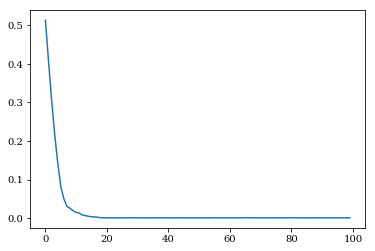

In [130]:
val_loss = history['val_loss']
plt.plot(range(epochs), val_loss,label='acc' , )

## 生成预测波形

In [131]:
'''
使用输出进行预测
'''
truncate = maxlen
Z = X[:1]  # 只取出原数据最开始的部分

original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequences - maxlen + 1):
    # 根据最后的时间序列数据预测未来
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict={
        x: Z[-1:],
        n_batch: 1
    })
    # 使用预测结果生成新的时间序列数据
    sequence_ = np.concatenate(
        (z_.reshape(maxlen, n_in)[1:], y_), axis=0) \
        .reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))



## 通过图表进行可视化
* 绿色是预测的
* 红色是原始的

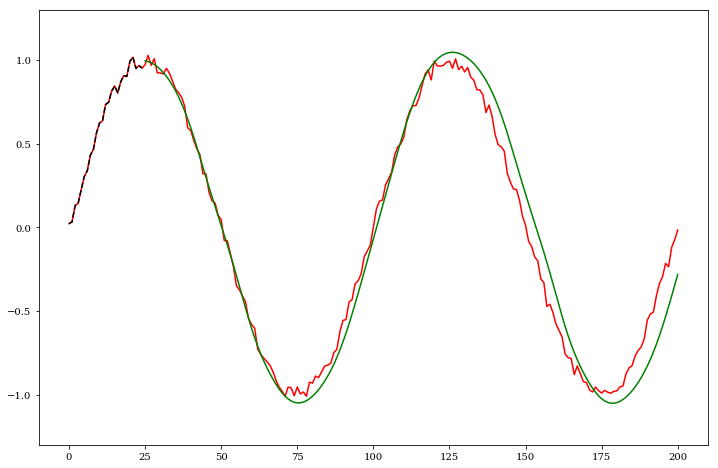

In [132]:

plt.rc('font', family='serif')
plt.figure(figsize=(12,8))
plt.ylim([-1.3, 1.3])
plt.plot(toy_x, toy_y, color='red')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='green')
plt.show()


* 绿色是预测的
* 黑色是真实的

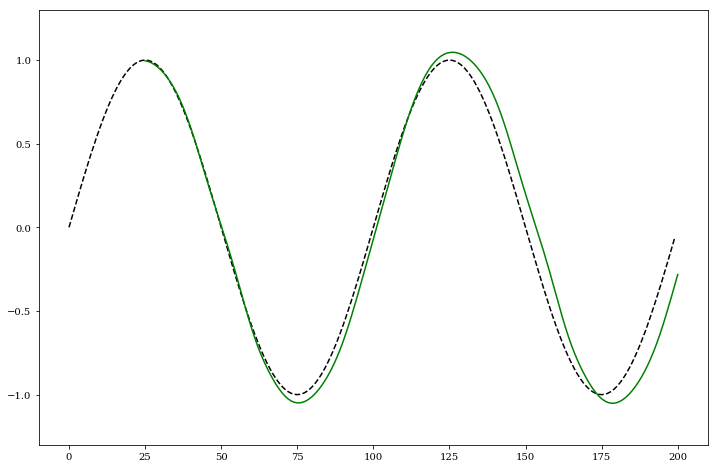

In [133]:
plt.rc('font', family='serif')
plt.figure(figsize=(12,8))
plt.ylim([-1.3, 1.3])
plt.plot(real, linestyle='dashed', color='black')
plt.plot(predicted, color='green')
plt.show()